In [30]:
import requests
import json
import pandas as pd
import numpy as np
import math
import itertools

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm
import scipy.stats as stats
import statsmodels.formula.api as smf

import time

import data_prep as dp

# Games Data

## Creating function to request data 

In [2]:
def get_games_data(page=1, per_page=100, total_pages=None):
    
    # Get number of pages
    url = 'https://www.balldontlie.io/api/v1/games'
    parameters = {'per_page': per_page, 'page': page, 'postseason': True}
    
    resp = requests.get(url, params=parameters).json()
    total_pages = min(x for x in [resp['meta']['total_pages'], total_pages] if x is not None)
    
    # Initialize data frame
    games_data = pd.DataFrame()
        
    for page_num in range(page, total_pages+1):
                
        # Make request
        parameters = {'page': page_num, 'per_page': per_page, 'postseason': True}
        
        resp = requests.get(url, params=parameters).json()
        
        # Create dataframe from json data key
        data = pd.DataFrame.from_records(resp['data'])    
        
        # Creating columns out of the dictionary-type columns
        for col in data.columns:
            if type(data[col][0]) == dict:
                for k in data[col][0].keys():
                    data[col+"_"+k] = data[col].apply(lambda x: x[k])
        
        # Concat data frames
        games_data = pd.concat([games_data, data])
        
        # Delay next request
        time.sleep(.8)
        
    return games_data

In [32]:
games_data = dp.get_games_data()

In [4]:
games_data.to_csv('games_data.csv', index=False)

In [33]:
games_data = pd.read_csv('games_data.csv')

In [34]:
games_data.head()

,date,home_team,home_team_score,id,period,postseason,season,status,time,visitor_team,...,home_team_division,home_team_full_name,home_team_name,visitor_team_id,visitor_team_abbreviation,visitor_team_city,visitor_team_conference,visitor_team_division,visitor_team_full_name,visitor_team_name
0,1996-04-26,"{'id': 5, 'abbreviation': 'CHI', 'city': 'Chic...",102,1218,4,True,1995,Final,,"{'id': 16, 'abbreviation': 'MIA', 'city': 'Mia...",...,Central,Chicago Bulls,Bulls,16,MIA,Miami,East,Southeast,Miami Heat,Heat
1,1996-04-27,"{'id': 29, 'abbreviation': 'UTA', 'city': 'Uta...",105,1219,4,True,1995,Final,,"{'id': 25, 'abbreviation': 'POR', 'city': 'Por...",...,Northwest,Utah Jazz,Jazz,25,POR,Portland,West,Northwest,Portland Trail Blazers,Trail Blazers
2,1996-04-28,"{'id': 22, 'abbreviation': 'ORL', 'city': 'Orl...",92,1220,4,True,1995,Final,,"{'id': 9, 'abbreviation': 'DET', 'city': 'Detr...",...,Southeast,Orlando Magic,Magic,9,DET,Detroit,East,Central,Detroit Pistons,Pistons
3,1996-04-30,"{'id': 26, 'abbreviation': 'SAC', 'city': 'Sac...",89,1221,4,True,1995,Final,,"{'id': 21, 'abbreviation': 'OKC', 'city': 'Okl...",...,Pacific,Sacramento Kings,Kings,21,OKC,Oklahoma City,West,Northwest,Oklahoma City Thunder,Thunder
4,1996-05-01,"{'id': 20, 'abbreviation': 'NYK', 'city': 'New...",81,1222,4,True,1995,Final,,"{'id': 6, 'abbreviation': 'CLE', 'city': 'Clev...",...,Atlantic,New York Knicks,Knicks,6,CLE,Cleveland,East,Central,Cleveland Cavaliers,Cavaliers


# Hypothesis 1: West_Score = B0 + B1 East_Score

## Creating function to shape dataframe

id, East Score, West Score

In [4]:
def games_data_east_west(data):
    
    # Filter to only include games where East plays West team
    data = data.loc[((data['home_team_conference']=="East")
                     &(data['visitor_team_conference']=="West")) 
                    | ((data['home_team_conference']=="West")
                       &(data['visitor_team_conference']=="East"))].copy()

    # Creating East columns
    data['east_team'] = np.where(data['home_team_conference']=="East",
                                 data['home_team_full_name'],
                                 data['visitor_team_full_name'])
    data['east_score'] = np.where(data['home_team_conference']=="East",
                                  data['home_team_score'], 
                                  data['visitor_team_score'])
    
    # Creating West columns
    data['west_team'] = np.where(data['home_team_conference']=="West",
                                 data['home_team_full_name'],
                                 data['visitor_team_full_name'])
    data['west_score'] = np.where(data['home_team_conference']=="West",
                                  data['home_team_score'],
                                  data['visitor_team_score'])
    
    # Creating Difference column
    data['east_minus_west'] = (data['east_score']
                               - data['west_score'])
    
    # Creating Winner column
    data['division_winner'] = np.where(data['west_score']
                                       > data['east_score'],"West","East")
    
    # Calling only the columns we need
    data = data[['id', 'season', 'east_team', 'east_score',
                 'west_team', 'west_score', 'east_minus_west',
                 'division_winner', 'postseason']]

    return data

In [35]:
east_west_games = dp.make_east_west_df(games_data)

In [36]:
east_west_games

,id,east_team,east_score,west_team,west_score,east_minus_west
101,1740,Chicago Bulls,122,Portland Trail Blazers,89,33
102,1741,Chicago Bulls,104,Portland Trail Blazers,115,-11
103,1742,Chicago Bulls,94,Portland Trail Blazers,84,10
104,1743,Chicago Bulls,88,Portland Trail Blazers,93,-5
105,1744,Chicago Bulls,119,Portland Trail Blazers,106,13
106,1745,Chicago Bulls,97,Portland Trail Blazers,93,4
121,1805,Chicago Bulls,107,Oklahoma City Thunder,90,17
122,1806,Chicago Bulls,92,Oklahoma City Thunder,88,4
123,1807,Chicago Bulls,108,Oklahoma City Thunder,86,22
124,1808,Chicago Bulls,86,Oklahoma City Thunder,107,-21


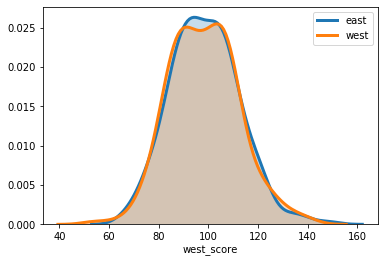

In [13]:
sns.distplot(east_west_games["east_score"], hist = False, kde_kws = {'shade': True, 'linewidth': 3}, label = "east")
sns.distplot(east_west_games["west_score"], hist = False, kde_kws = {'shade': True, 'linewidth': 3}, label = "west");

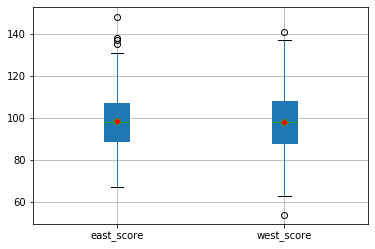

In [27]:
boxplot = east_west_games.boxplot(["east_score", "west_score"],
                                  patch_artist=True,
                                  showmeans=True,
                                  boxprops=dict(facecolor="blue"),
                                  meanprops=dict(marker="D", markerfacecolor="red"));
# plt.boxplot(east_west_games["east_score"], patch_artist=True, boxprops=dict(facecolor='blue'));

In [30]:
t_test = stats.ttest_rel(east_west_games["east_score"], east_west_games["west_score"])
t_test

Ttest_relResult(statistic=0.4981434564959921, pvalue=0.6188226223515709)

In [32]:
diff_mean = east_west_games["east_minus_west"].mean()
diff_sd = east_west_games["east_minus_west"].std()
t = round(t_test[0], 4)
n = len(east_west_games["east_minus_west"])
lower = diff_mean - t*(diff_sd / n)
upper = diff_mean + t*(diff_sd / n)
lower, upper

(0.3896921450836041, 0.44230785491639585)

In [33]:
west_wins = pd.DataFrame(east_west_games.loc[east_west_games["division_winner"]
                                             == "West"].groupby("season")["id"].count())
east_wins = pd.DataFrame(east_west_games.loc[east_west_games["division_winner"]
                                             == "East"].groupby("season")["id"].count())
division_wins = pd.merge(west_wins, east_wins, on="season", suffixes=('_west', '_east'))
division_wins.columns = ["west_wins", "east_wins"]
division_wins.head()

,west_wins,east_wins
season,,
1979,8,9
1980,2,4
1981,4,2
1983,3,4
1984,4,2


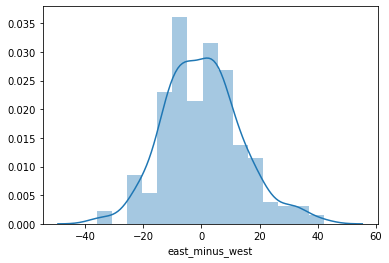

In [36]:
sns.distplot(east_west_games['east_minus_west']);

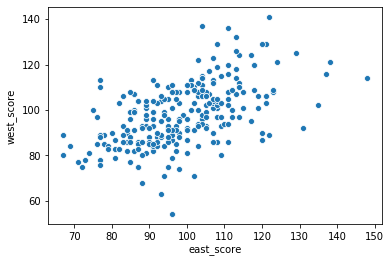

In [38]:
sns.scatterplot(data=east_west_games,
                x='east_score',
                y='west_score');

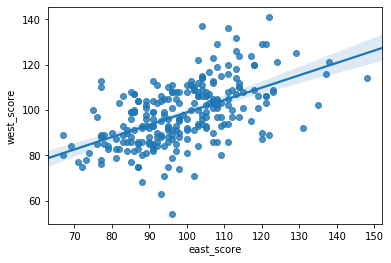

In [39]:
sns.regplot(data=east_west_games,
            x='east_score',
            y='west_score');

## Create regression function

In [41]:
X = east_west_games['east_score']
y = east_west_games['west_score']
X = sm.add_constant(X)
mod = sm.OLS(y, X, hasconst= True)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             west_score   R-squared:                       0.292
Model:                            OLS   Adj. R-squared:                  0.290
Method:                 Least Squares   F-statistic:                     102.5
Date:                Tue, 08 Oct 2019   Prob (F-statistic):           2.17e-20
Time:                        20:59:06   Log-Likelihood:                -967.95
No. Observations:                 250   AIC:                             1940.
Df Residuals:                     248   BIC:                             1947.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         44.3609      5.371      8.260      0.000      33.783      54.939
east_score     0.5460      0.054     10.125      0.000       0.440       0.652
==============================================================================
Omnibus:                        3.565   Durbin-Watson:                   1.693
Prob(Omnibus):                  0.168   Jarque-Bera (JB):                4.132
Skew:                          -0.062   Prob(JB):                        0.127
Kurtosis:                       3.618   Cond. No.                         725.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Hypothesis 2: No Team has Better Home Court Advantage

In [42]:
def home_games_data(data):
    
    data['home_win'] = (data['home_team_score']
                        > data['visitor_team_score'])*1
    
    data['home_score_diff'] = (data['home_team_score']
                               - data['visitor_team_score'])
    
    data = data[['id', 'home_team_full_name', 'home_team_score',
                 'home_score_diff', 'home_win', 'home_team_conference']]

    return data

In [48]:
home_game_data = dp.make_home_df(games_data, "West", 5)

In [49]:
home_game_data["home_team_full_name"].unique()

array(['Utah Jazz', 'Oklahoma City Thunder', 'Los Angeles Lakers',
       'San Antonio Spurs', 'Golden State Warriors'], dtype=object)

In [46]:
east_home = home_games_data.loc[home_games_data["home_team_conference"] 
                                == "East"]
east_home

,id,home_team_full_name,home_team_score,home_score_diff,home_win,home_team_conference
0,1218,Chicago Bulls,102,17,1,East
2,1220,Orlando Magic,92,15,1,East
4,1222,New York Knicks,81,5,1,East
8,1226,Chicago Bulls,91,7,1,East
9,1332,Cleveland Cavaliers,120,7,1,East
11,1334,Boston Celtics,119,7,1,East
13,1336,Indiana Pacers,98,-4,0,East
18,1380,Miami Heat,91,-21,0,East
19,1405,New York Knicks,109,10,1,East
20,1406,Chicago Bulls,98,12,1,East


In [140]:
teams = east_home["home_team_full_name"].unique()
east_games = pd.DataFrame(teams, columns=["team"])
east_games["score_diff_mean"] = east_home.groupby("home_team_full_name") \
                                ["home_score_diff"].mean().values
east_games = east_games.sort_values(by=["score_diff_mean"],
                                    ascending=False)
east_games['team_names'] = east_games["team"].apply(lambda x:
                                                    x.lower().replace(" ", "_"))
east_games

,team,score_diff_mean,team_names
6,Miami Heat,6.833333,miami_heat
5,Indiana Pacers,6.326923,indiana_pacers
8,Detroit Pistons,5.965812,detroit_pistons
1,Orlando Magic,5.949749,orlando_magic
4,Boston Celtics,5.197279,boston_celtics
3,Cleveland Cavaliers,4.428571,cleveland_cavaliers
11,Charlotte Hornets,4.000000,charlotte_hornets
7,Washington Wizards,3.991304,washington_wizards
12,Milwaukee Bucks,3.669492,milwaukee_bucks
13,Philadelphia 76ers,3.490566,philadelphia_76ers


In [84]:
east_teams = list(east_games.iloc[:, :5].columns)
east_teams

['detroit_pistons',
 'cleveland_cavaliers',
 'miami_heat',
 'boston_celtics',
 'chicago_bulls']

In [51]:
west_home = home_games_data.loc[home_games_data["home_team_conference"]
                                == "West"]
west_home

,id,home_team_full_name,home_team_score,home_score_diff,home_win,home_team_conference
1,1219,Utah Jazz,105,15,1,West
3,1221,Sacramento Kings,89,-7,0,West
5,1223,Sacramento Kings,87,-14,0,West
6,1224,Phoenix Suns,98,-18,0,West
7,1225,Oklahoma City Thunder,108,33,1,West
10,1333,Phoenix Suns,117,6,1,West
12,1335,Utah Jazz,103,11,1,West
14,1337,Oklahoma City Thunder,129,1,1,West
15,1377,Oklahoma City Thunder,97,12,1,West
16,1378,Los Angeles Lakers,104,10,1,West


In [120]:
west_home.loc[west_home["home_team_full_name"]=="Utah Jazz"]["home_score_diff"]

1       15
12      11
21       6
42       6
53      38
59      30
63       9
65       8
71      11
93       8
95       9
99      -8
109     27
114     20
116     -2
119     35
137      5
146     15
148     12
154      5
159     11
160      5
161     -2
194      5
199     10
201    -13
256     33
261      9
286     10
293     10
        ..
2120    -5
2158   -26
2184    13
2357     2
2388   -16
2422    -5
2426    16
2428    14
2430     3
2457    10
2459    -5
2471    12
2515    15
2519   -13
2548     5
2558    -2
2563    -4
2589     2
2601     8
2639    28
2666     8
2668    -7
2747     7
2761    17
2776    -2
2830    -4
2841    -8
2885   -18
2918    16
2925    -3
Name: home_score_diff, Length: 135, dtype: int64

In [141]:
teams = west_home["home_team_full_name"].unique()
west_games = pd.DataFrame(teams, columns=["team"])
west_games["score_diff_mean"] = west_home.groupby("home_team_full_name") \
                                ["home_score_diff"].mean().values
west_games = west_games.sort_values(by=["score_diff_mean"],
                                    ascending=False)
west_games['team_names'] = west_games["team"].apply(lambda x:
                                                    x.lower().replace(" ", "_"))
west_games

,team,score_diff_mean,team_names
2,Phoenix Suns,7.559524,phoenix_suns
5,San Antonio Spurs,7.373913,san_antonio_spurs
13,New Orleans Pelicans,7.315789,new_orleans_pelicans
9,Golden State Warriors,5.474453,golden_state_warriors
14,Memphis Grizzlies,4.992593,memphis_grizzlies
10,Denver Nuggets,4.350427,denver_nuggets
3,Oklahoma City Thunder,3.765957,oklahoma_city_thunder
0,Utah Jazz,3.617021,utah_jazz
1,Sacramento Kings,3.000000,sacramento_kings
4,Los Angeles Lakers,2.534884,los_angeles_lakers


In [82]:
west_teams = list(west_games.iloc[:, :5].columns)
west_teams

['golden_state_warriors',
 'los_angeles_lakers',
 'san_antonio_spurs',
 'oklahoma_city_thunder',
 'utah_jazz']

In [61]:
east = list(itertools.combinations(east_teams, 2))
east

[('detroit_pistons', 'cleveland_cavaliers'),
 ('detroit_pistons', 'miami_heat'),
 ('detroit_pistons', 'boston_celtics'),
 ('detroit_pistons', 'chicago_bulls'),
 ('cleveland_cavaliers', 'miami_heat'),
 ('cleveland_cavaliers', 'boston_celtics'),
 ('cleveland_cavaliers', 'chicago_bulls'),
 ('miami_heat', 'boston_celtics'),
 ('miami_heat', 'chicago_bulls'),
 ('boston_celtics', 'chicago_bulls')]

In [62]:
west = list(itertools.combinations(west_teams, 2))
west

[('golden_state_warriors', 'los_angeles_lakers'),
 ('golden_state_warriors', 'san_antonio_spurs'),
 ('golden_state_warriors', 'oklahoma_city_thunder'),
 ('golden_state_warriors', 'utah_jazz'),
 ('los_angeles_lakers', 'san_antonio_spurs'),
 ('los_angeles_lakers', 'oklahoma_city_thunder'),
 ('los_angeles_lakers', 'utah_jazz'),
 ('san_antonio_spurs', 'oklahoma_city_thunder'),
 ('san_antonio_spurs', 'utah_jazz'),
 ('oklahoma_city_thunder', 'utah_jazz')]